In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve, IsotonicRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from tqdm import tqdm, trange

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

import mlflow
from utils import log_mlflow, create_submission, apply_isotonic_regression, compare_calibration_curves
from tree_based_lr import TreeBasedLR

In [2]:
DATA_DIR = 'data/'
Y_TRAIN_PATH = DATA_DIR + 'y_train.csv.gz'

X = pd.read_csv('output/X_train_full.csv')
y = pd.read_csv(Y_TRAIN_PATH, compression='gzip')

In [3]:
class DatasetHandler:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def split_dataset(self):
        self.X_train, X_valid, self.y_train, y_valid = train_test_split(self.X, self.y, train_size=0.8, random_state=42)
        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(X_valid, y_valid, train_size=0.5, random_state=42)
        
    @staticmethod
    def smoothed_stat(df, smoothed_factor, prefix):
        df[f'{prefix}_ctr'] = (smoothed_factor['ctr'] * 100 + df[f'{prefix}_clicks']) / (100 + df[f'{prefix}_count'])
        df[f'{prefix}_cr'] = (smoothed_factor['cr'] * 100 + df[f'{prefix}_sales']) / (100 + df[f'{prefix}_count'])
        df[f'{prefix}_ccr'] = (smoothed_factor['ccr'] * 100 + df[f'{prefix}_sales']) /(100 + df[f'{prefix}_clicks'])
        return df
    
    def get_smoothed_factor(self):
        smoothed_factor = {
            'count': 0, 
            'clicks': 0, 
            'sales': 0,
            'freq': 0,
            'ctr': np.mean(self.y_train['click']),
            'cr': np.mean(self.y_train['sale']),
            'ccr': np.mean(self.y_train[self.y_train['click'] == 1]['sale']) 
        } 
        return smoothed_factor
                
    def preprocess_dataframes(self):

        hash_cols = {f'hash_{i}' for i in range(19)}
        train_cols = list(set(self.X_train.columns) - hash_cols)
        smoothed_factor = self.get_smoothed_factor()

        for dataset in (self.X_train, self.X_valid, self.X_test):
            for i in trange(19):
                dataset = self.smoothed_stat(dataset, smoothed_factor, f'feature{i}')
                for j in trange(19):
                    if i < j:
                        dataset = self.smoothed_stat(dataset, smoothed_factor, f'feature{i}_feature{j}')

            for col in train_cols:
                stat = col.split('_')[-1]
                if stat in smoothed_factor:
                    dataset[col] = dataset[col].replace([np.inf, -np.inf], np.nan).fillna(smoothed_factor[stat])

        return self.X_train[train_cols], self.X_valid[train_cols], self.y_train['click'], self.y_valid['click'], self.X_test[train_cols], self.y_test
    

In [4]:
data_handler = DatasetHandler(X, y)
data_handler.split_dataset()
X_train, X_valid, y_train, y_valid, X_test, y_test = data_handler.preprocess_dataframes()


  0%|          | 0/19 [00:00<?, ?it/s]/home/apanin/.local/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)

  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/conda/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
/usr/local/conda/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

In [5]:
# params

models_params = {
    'lr': {
        'solver':'sag',
        'C': 0.001,
        'fit_intercept': False,
    },
    'lgbm': {
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'boost': 'gbdt',
        'feature_fraction': 0.8,
        'learning_rate': 0.01,
        'metric':'binary',
        'num_leaves': 31,
        'num_threads': 8,
        'objective': 'binary',
        'seed': 42,
    }
}


In [6]:
# vanilla lgbm model
tr = lgb.Dataset(np.array(X_train), np.array(y_train))
te = lgb.Dataset(np.array(X_valid), np.array(y_valid), reference=tr)
model = lgb.train(
    models_params['lgbm'], 
    tr, 
    num_boost_round=10000, 
    valid_sets=te, 
    early_stopping_rounds=int(5 / models_params['lgbm']['learning_rate']), 
    verbose_eval=100,
)
pred_val = model.predict(X_valid)
pred_te = model.predict(X_test)


[LightGBM] [Info] Number of positive: 8158, number of negative: 73789
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122973
[LightGBM] [Info] Number of data points in the train set: 81947, number of used features: 760
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099552 -> initscore=-2.202211
[LightGBM] [Info] Start training from score -2.202211
Training until validation scores don't improve for 500 rounds
[100]	valid_0's binary_logloss: 0.274529
[200]	valid_0's binary_logloss: 0.258128
[300]	valid_0's binary_logloss: 0.250374
[400]	valid_0's binary_logloss: 0.246202
[500]	valid_0's binary_logloss: 0.244044
[600]	valid_0's binary_logloss: 0.242711
[700]	valid_0's binary_logloss: 0.241846
[800]	valid_0's binary_logloss: 0.241339
[900]	valid_0's binary_logloss: 0.241019
[1000]	valid_0's binary_logloss: 0.240785
[1100]	valid_0's binary_logl

In [7]:
tblr = TreeBasedLR(models_params['lgbm'], models_params['lr'], forest_model='lgbm')
tblr.fit(X_train, y_train)

pred_val_tblr = tblr.predict_proba(X_valid)[:,1]
pred_te_tblr = tblr.predict_proba(X_test)[:,1]


[LightGBM] [Warning] boosting is set with boosting_type=gbdt, will be overridden by boost=gbdt. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [8]:
# tree based logistic regression
leaves = model.predict(X_valid, pred_leaf=True)
encoder = OneHotEncoder(handle_unknown='ignore')
leaves_encoded = encoder.fit_transform(leaves)

lr = LogisticRegression(**models_params['lr'])
lr.fit(leaves_encoded, y_valid)
pred_val_tblr_adj = lr.predict_proba(leaves_encoded)[:,1]

leaves = model.predict(X_test, pred_leaf=True)
leaves_encoded = encoder.transform(leaves)
pred_te_tblr_adj = lr.predict_proba(leaves_encoded)[:,1]


In [9]:
# isotonic regression
pred_val_cal = apply_isotonic_regression(pred_val, y_valid, pred_val)
pred_te_cal = apply_isotonic_regression(pred_val, y_valid, pred_te)


### validation results

In [10]:
val_metrics = {
    'lgbm:': log_loss(y_valid, pred_val),
    'lgbm+isotonic:': log_loss(y_valid, pred_val_cal),
    'lgbm+tblr:': log_loss(y_valid, pred_val_tblr),
    'lgbm+tblr_adj:': log_loss(y_valid, pred_val_tblr_adj),
}
val_metrics

{'lgbm:': 0.24002620105747716,
 'lgbm+isotonic:': 0.237197472688019,
 'lgbm+tblr:': 0.25288482263329504,
 'lgbm+tblr_adj:': 0.20832311171588402}

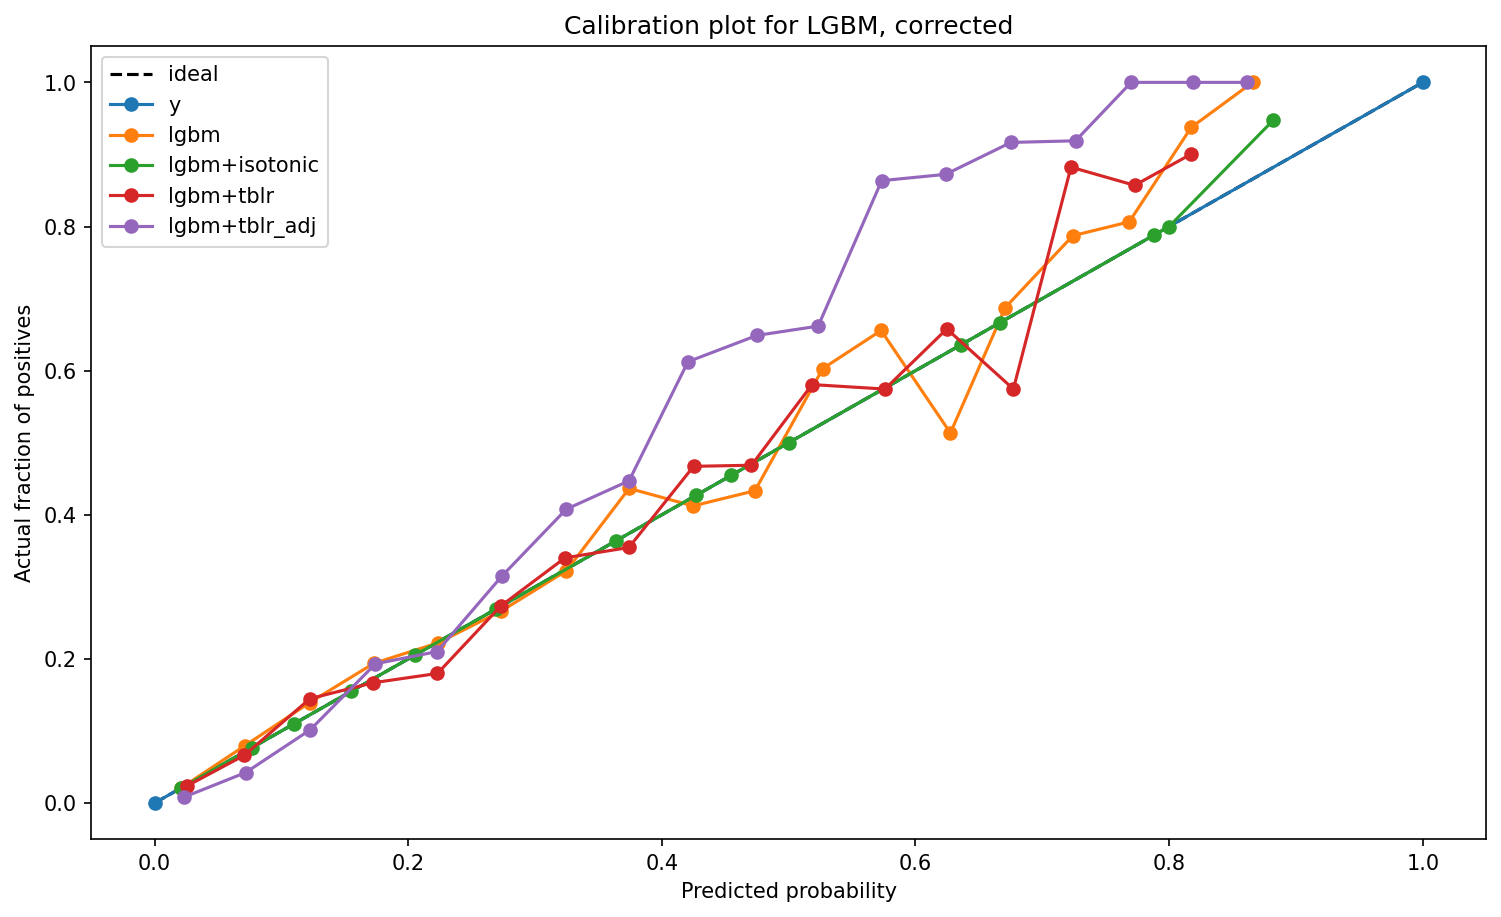

In [11]:
# результаты на валидации

prediction_dataframe = pd.DataFrame(
    {'y': y_valid, 
     'lgbm': pred_val, 
     'lgbm+isotonic': pred_val_cal, 
     'lgbm+tblr': pred_val_tblr,
     'lgbm+tblr_adj': pred_val_tblr_adj,
    }
)

compare_calibration_curves(prediction_dataframe)

### test results


In [12]:
te_metrics = {
    'lgbm:': log_loss(y_test, pred_te),
    'lgbm+isotonic:': log_loss(y_test, pred_te_cal),
    'lgbm+tblr:': log_loss(y_test, pred_te_tblr),
    'lgbm+tblr_adj:': log_loss(y_test, pred_te_tblr_adj),
}
te_metrics

{'lgbm:': 0.048111383829725705,
 'lgbm+isotonic:': 0.05183620985303712,
 'lgbm+tblr:': 0.0448817100226462,
 'lgbm+tblr_adj:': 0.0455648920383748}

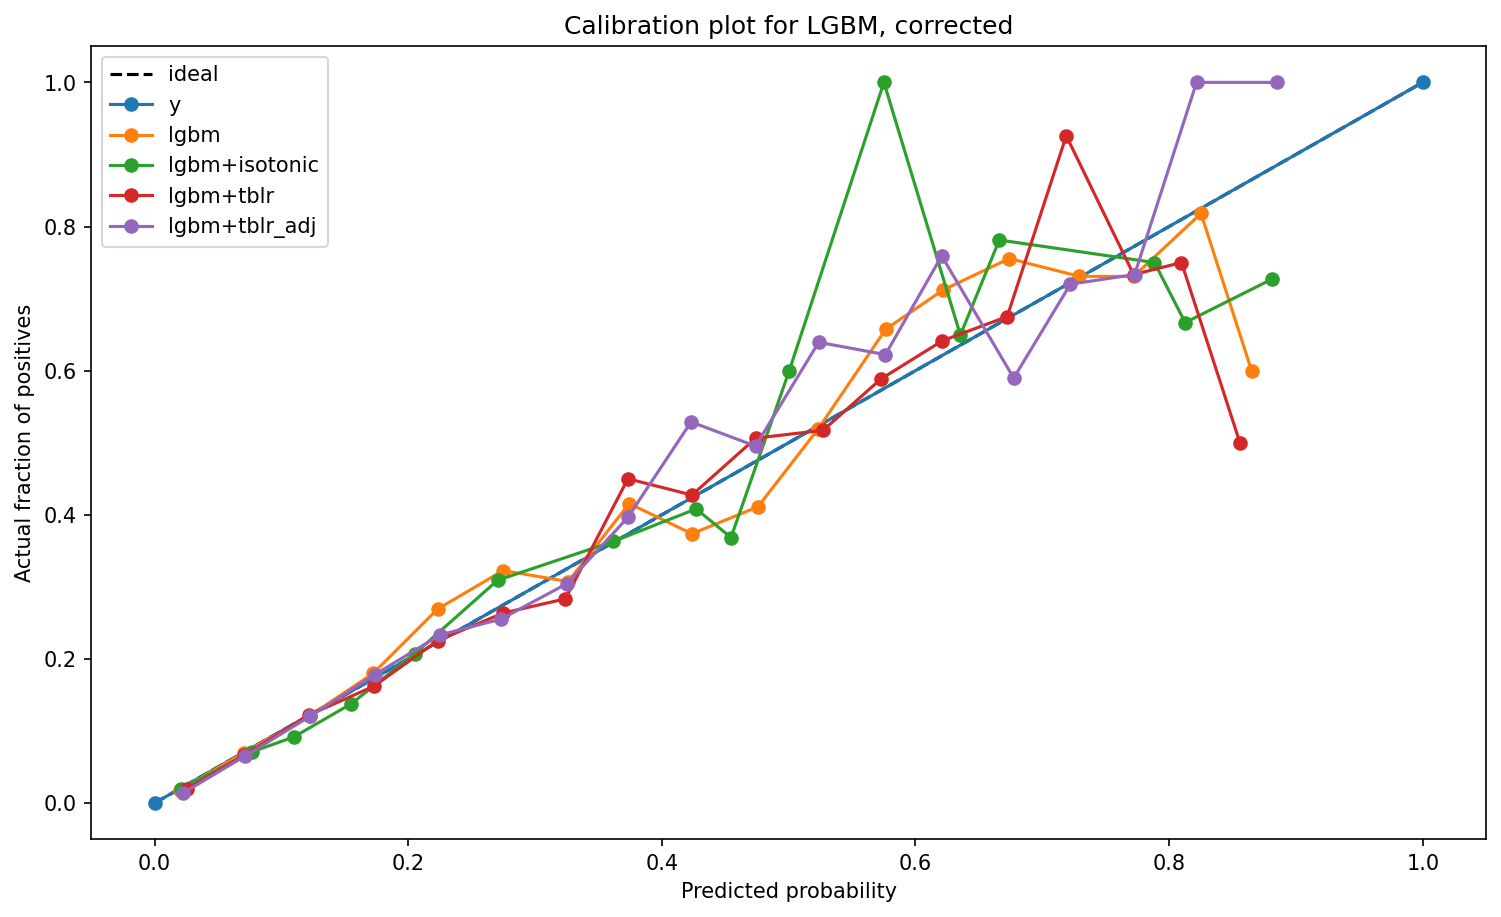

In [13]:
prediction_dataframe = pd.DataFrame(
    {'y': y_test['click'], 
     'lgbm': pred_te, 
     'lgbm+isotonic': pred_te_cal, 
     'lgbm+tblr': pred_te_tblr,
     'lgbm+tblr_adj': pred_te_tblr_adj,
    }
)

compare_calibration_curves(prediction_dataframe)